In [1]:
!pip install imblearn

In [2]:
# basic
import numpy as np
import pandas as pd
import time

# plot & diagram
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# imbalance learning (mainly SMOTE)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

# statistics
from scipy.stats import norm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score \
, accuracy_score, classification_report, average_precision_score, precision_recall_curve, confusion_matrix


# spark functions
from pyspark.sql import SparkSession
import pyspark.sql.functions as col
from pyspark.ml.feature import StandardScaler, RobustScaler, VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import udf
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import DoubleType
import pyspark.sql.functions as F

In [3]:
t0 = time.time()

In [4]:
spark = SparkSession.builder \
    .appName('Card Fraud') \
    .getOrCreate()

In [5]:
# dataset -> https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
df = spark.read.option('header',True).option('inferSchema',True).csv('hdfs:///data/creditcard.csv')

In [6]:
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [7]:
# imbalanced data
df.groupBy('Class').count().show()

+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+



22/05/30 07:28:49 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

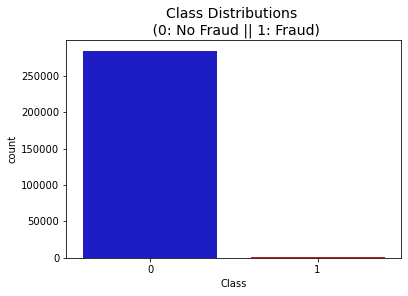

In [8]:
colors = ["#0101DF", "#DF0101"]
df_pandas = df.toPandas()

sns.countplot('Class', data=df_pandas, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


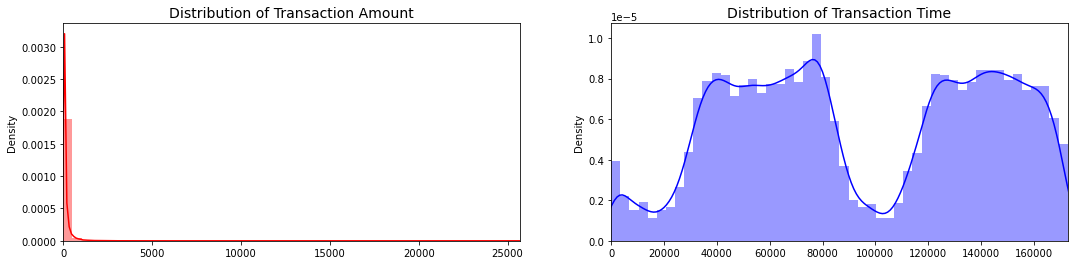

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df_pandas['Amount'].values
time_val = df_pandas['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])


plt.show()

In [10]:
# This is equivalent to UNION ALL in SQL
df2 = df.union(df.select(*[F.avg(c).alias(c) for c in df.columns]))

# All columns are PCA standartized, exception are Amount and Time, we will standartise them below
va_std = VectorAssembler(inputCols=["Amount"], outputCol="temp_feature")
va_rob = VectorAssembler(inputCols=["Time"], outputCol="temp_feature")

tmpdf = va_std.transform(df2)

std_scaler = StandardScaler(inputCol='temp_feature', outputCol='scaled_amount', withStd=True, withMean=True)
scalerStdModel = std_scaler.fit(tmpdf)
scaledStdData = scalerStdModel.transform(tmpdf)
df3 = scaledStdData.drop('temp_feature','Amount')

tmpdf = va_rob.transform(df3)

# RobustScaler is less prone to outliers.
rob_scaler = RobustScaler(
    inputCol='temp_feature',
    outputCol='scaled_time',
    withScaling=True,
    withCentering=True,
    lower=0.25,
    upper=0.75
)
scalerRobModel = rob_scaler.fit(tmpdf)
scalerRobData = scalerRobModel.transform(tmpdf)
df3 = scalerRobData.drop('temp_feature','Time')

# transform from Vector Assembler back to 1 element (VA have only 1 element now, so it's safe)
firstelement=udf(lambda v:float(v[0]),DoubleType())


df3 = df3.withColumn('scaled_time', firstelement('scaled_time'))
df3 = df3.withColumn('scaled_amount', firstelement('scaled_amount'))
# cache the df for better results further
df3.cache()
df3.toPandas().head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.0,0.244964,-0.994302
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.0,-0.342475,-0.994302
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0.0,1.160686,-0.994290
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.0,0.140534,-0.994290
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.0,-0.073403,-0.994279


In [11]:
# we are splitting it in 0.8 train data and 0.2 test data
# Important! because data are imbalanced, we are splitting it to have the same perc (%)
# in train (80%) and test (20%) data
train_df = df3.stat.sampleBy('Class',fractions={0:0.8,1:0.8},seed=0)
train_df.groupBy('Class').count().show()

+-----+------+
|Class| count|
+-----+------+
|  0.0|227029|
|  1.0|   393|
+-----+------+



In [12]:
test_df = df3.stat.sampleBy('Class',fractions={0:0.2,1:0.2},seed=0)
test_df.groupBy('Class').count().show()

+-----+-----+
|Class|count|
+-----+-----+
|  0.0|56505|
|  1.0|  108|
+-----+-----+



In [13]:
# shuffle data
df4 = df3.sample(fraction=1.0)

In [14]:
# creating a new DF with balanced data, for training purpose
# it's unreal to train good classification algorithm on such imbalanced data
# without SMOTE tehnique, or without training it on smaller data (balanced)
fraud_df = df4.filter('Class == 1.0')
fraud_df.count()

492

In [15]:
non_fraud_df = df4.filter('Class == 0.0').limit(492)
non_fraud_df.count()

492

In [16]:
normal_distributed_df = fraud_df.union(non_fraud_df)
new_df = normal_distributed_df.sample(fraction=1.0,seed=42)
# caching for better result on optimisation further
new_df.cache()

DataFrame[V1: double, V2: double, V3: double, V4: double, V5: double, V6: double, V7: double, V8: double, V9: double, V10: double, V11: double, V12: double, V13: double, V14: double, V15: double, V16: double, V17: double, V18: double, V19: double, V20: double, V21: double, V22: double, V23: double, V24: double, V25: double, V26: double, V27: double, V28: double, Class: double, scaled_amount: double, scaled_time: double]

Distribution of the Classes in the subsample dataset


+-----+-----+
|Class|count|
+-----+-----+
|  0.0|  492|
|  1.0|  492|
+-----+-----+



/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


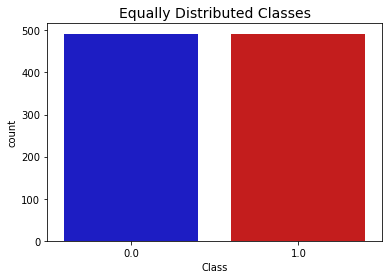

In [17]:

print('Distribution of the Classes in the subsample dataset')
new_df.groupBy('Class').count().show()


pandas_new_df = new_df.toPandas()
sns.countplot('Class', data=pandas_new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [18]:
pandas_new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,1.0,-0.353229,-0.989532
1,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1.0,1.761758,-0.988757
2,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,1.0,0.606031,-0.941881
3,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,1.0,-0.117342,-0.912229
4,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.0,-0.349231,-0.905967


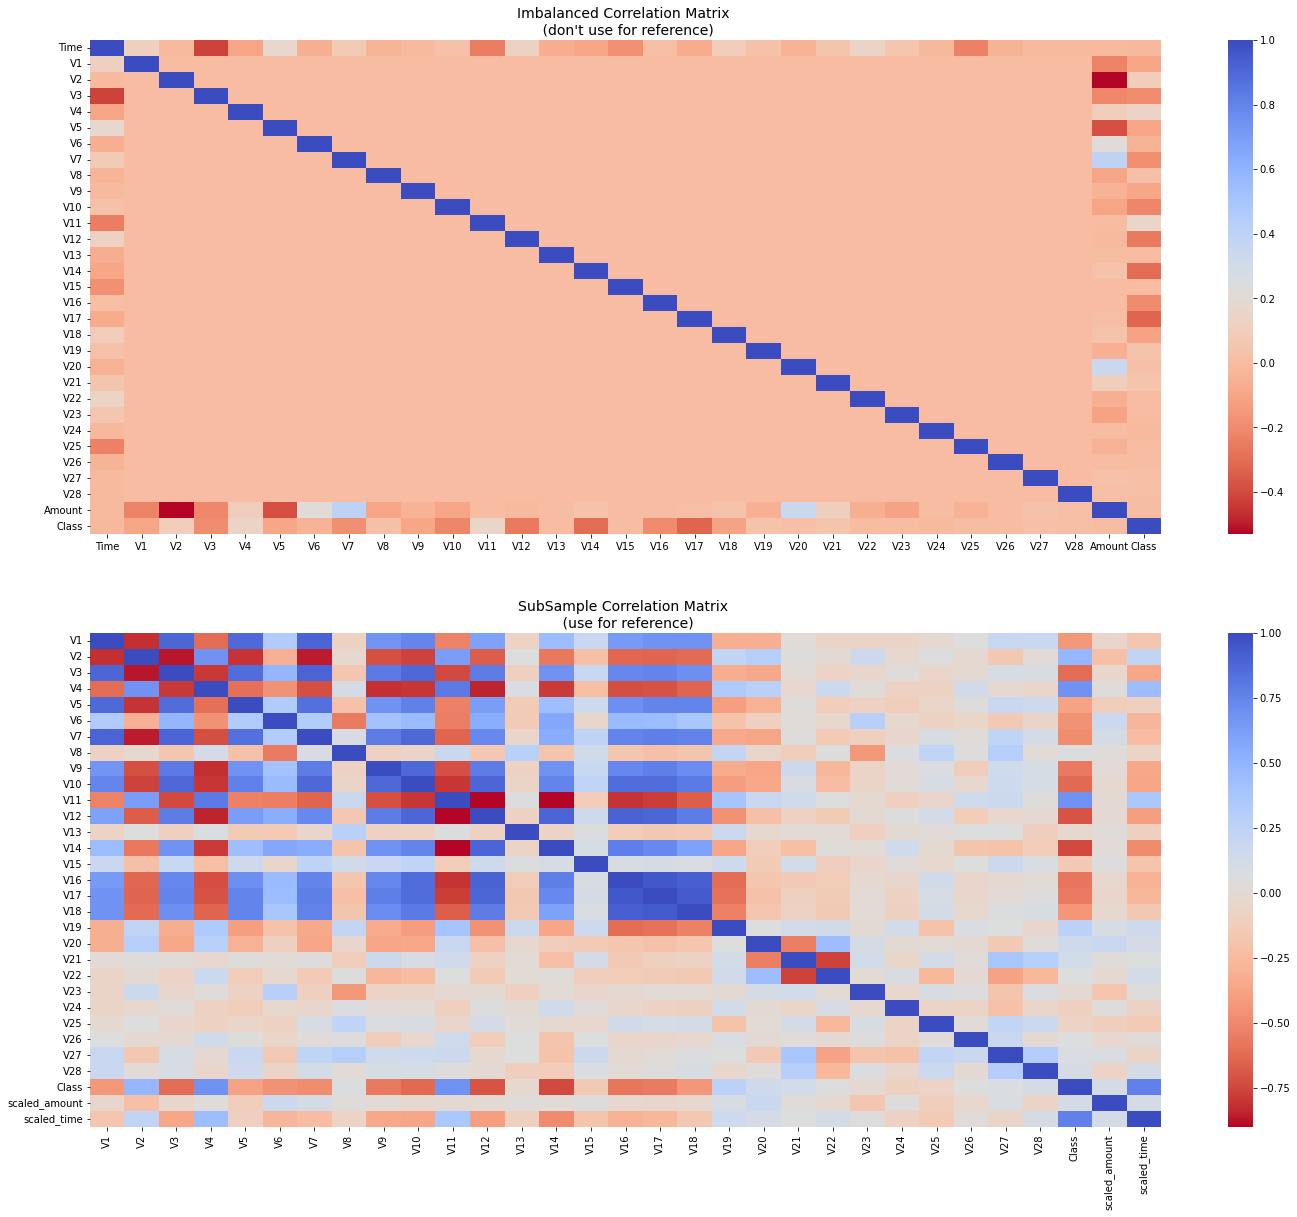

In [19]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df_pandas.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = pandas_new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

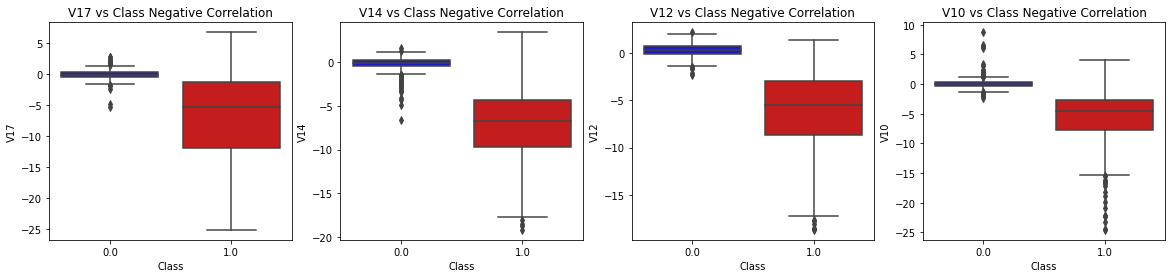

In [20]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=pandas_new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=pandas_new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=pandas_new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=pandas_new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

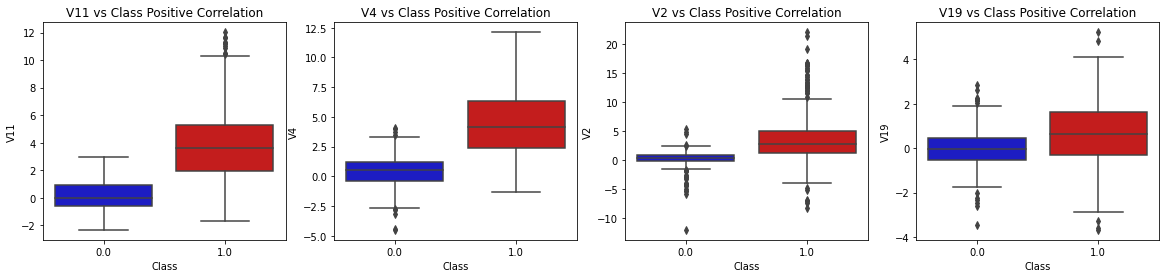

In [21]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=pandas_new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=pandas_new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=pandas_new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=pandas_new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `h

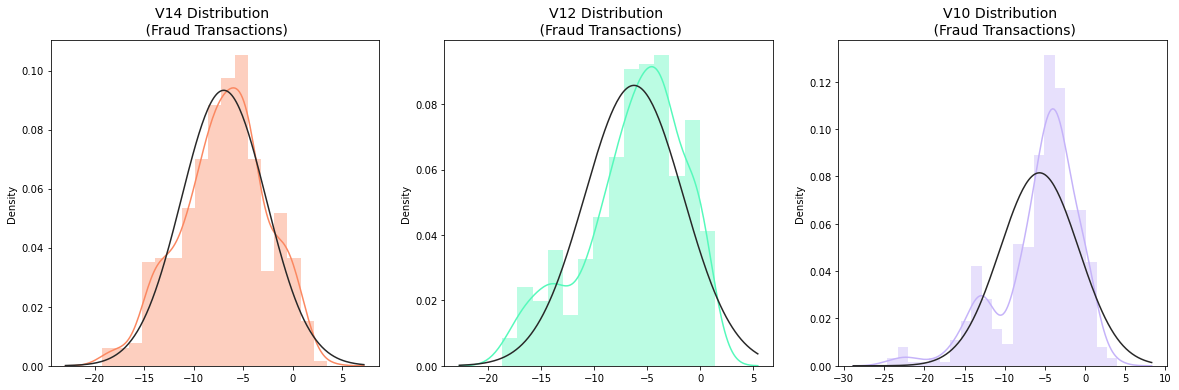

In [22]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df.select('V14').where('Class == 1.0')
sns.distplot(v14_fraud_dist.collect(),ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df.select('V12').where('Class == 1.0')
sns.distplot(v12_fraud_dist.collect(),ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df.select('V10').where('Class == 1.0')
sns.distplot(v10_fraud_dist.collect(),ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [23]:
new_df.count()

984

In [24]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
q25,q75 = np.percentile(v14_fraud_dist.collect(), 25), np.percentile(v14_fraud_dist.collect(), 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))
v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud_dist.collect() if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V14 outliers:{}'.format(outliers))
new_df = new_df.filter( (df.V14 < v14_upper) & (df.V14 > v14_lower))
print('Number of Instances after outliers removal: {}'.format(new_df.count()))
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
q25, q75 = np.percentile(v12_fraud_dist.collect(), 25), np.percentile(v12_fraud_dist.collect(), 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud_dist.collect() if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.filter( (df.V12 < v12_upper) & (df.V12 > v12_lower))
print('Number of Instances after outliers removal: {}'.format(new_df.count()))
print('----' * 44)



# -----> Removing outliers V10 Feature
q25, q75 = np.percentile(v10_fraud_dist.collect(), 25), np.percentile(v10_fraud_dist.collect(), 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v10_iqr = q75 - q25
# todo to test here if this is right
v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v12_fraud_dist.collect() if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.filter( (df.V10 < v10_upper) & (df.V10 > v10_lower))
print('Number of Instances after outliers removal: {}'.format(new_df.count()))
new_df.cache()
pandas_new_df = new_df.toPandas()

Quartile 25: -9.692722964972385 | Quartile 75: -4.282820849486866
iqr: 5.409902115485519
Cut Off: 8.114853173228278
V14 Lower: -17.807576138200663
V14 Upper: 3.8320323237414122
Feature V14 Outliers for Fraud Cases: 4
V14 outliers:[Row(V14=-19.2143254902614), Row(V14=-18.8220867423816), Row(V14=-18.4937733551053), Row(V14=-18.0499976898594)]
Number of Instances after outliers removal: 980
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Quartile 25: -8.688176521812306 | Quartile 75: -2.9740880253849302
V12 Lower: -17.25930926645337
V12 Upper: 5.597044719256134
V12 outliers: [Row(V12=-17.7691434633638), Row(V12=-17.6316063138707), Row(V12=-18.0475965708216), Row(V12=-18.6837146333443), Row(V12=-18.5536970096458), Row(V12=-18.4311310279993)]
Feature V12 Outliers for Fraud Cases: 6
Number of Instances after outliers removal: 976
-----------------------------------

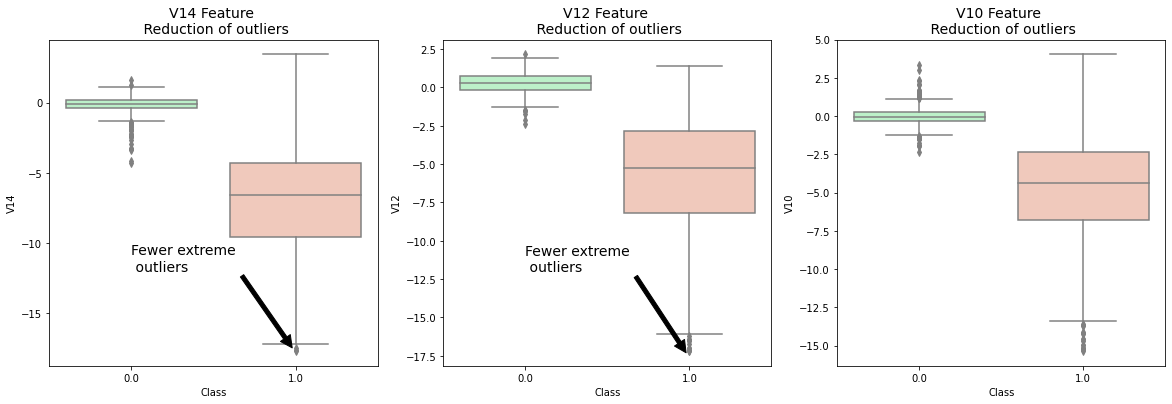

In [25]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=pandas_new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=pandas_new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=pandas_new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()


In [26]:
# New_df is from the random undersample data (fewer instances)
X = pandas_new_df.drop('Class', axis=1)
y = pandas_new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

/opt/conda/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


T-SNE took 4.9 s
PCA took 0.0078 s
Truncated SVD took 0.006 s


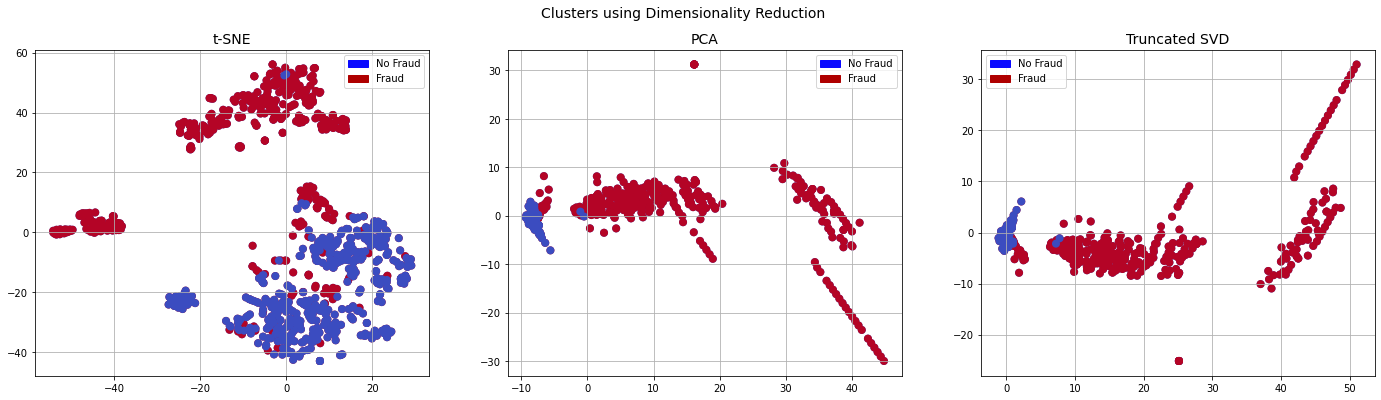

In [27]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

In [28]:
# Let's build a basic clasificator with Random Forest without much data aggregation
X = new_df.drop('Class')
y = new_df.select('Class')
X.show()

+-------------------+-----------------+------------------+----------------+------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+--------------------+------------------+-----------------+-------------------+-------------------+-------------------+------------------+--------------------+--------------------+-------------------+------------------+------------------+-------------------+------------------+--------------------+-------------------+
|                 V1|               V2|                V3|              V4|                V5|                 V6|                V7|                 V8|                V9|               V10|               V11|               V12|               V13|              V14|                 V15|               V16|              V17|                V18|                V19|                V20|               V21|             

In [29]:
cols = new_df.columns
cols.remove('Class')
cols

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'scaled_amount',
 'scaled_time']

In [30]:
assembler = VectorAssembler(inputCols=cols,outputCol='features')
rf_df = assembler.transform(new_df)
rf_df.show()

+-------------------+-----------------+------------------+----------------+------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+--------------------+------------------+-----------------+-------------------+-------------------+-------------------+------------------+--------------------+--------------------+-------------------+------------------+------------------+-------------------+------------------+-----+--------------------+-------------------+--------------------+
|                 V1|               V2|                V3|              V4|                V5|                 V6|                V7|                 V8|                V9|               V10|               V11|               V12|               V13|              V14|                 V15|               V16|              V17|                V18|                V19|                V20|     

In [31]:
rf_df = rf_df.withColumn("labelIndex", rf_df.Class)
rf_df.columns

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Class',
 'scaled_amount',
 'scaled_time',
 'features',
 'labelIndex']

In [32]:
rf_df_feat = rf_df.select('features','labelIndex')

In [33]:
(trainingData, testData) = rf_df_feat.randomSplit([0.7, 0.3],seed=1234)

In [34]:
rf = RandomForestClassifier(labelCol="labelIndex", featuresCol='features', numTrees=20)

In [35]:
rf_model = rf.fit(trainingData)

In [36]:
rf_df1 = assembler.transform(df3)
rf_df1 = rf_df1.withColumn("labelIndex", rf_df1.Class)

In [37]:
predictions = rf_model.transform(testData)

In [38]:
evaluator = BinaryClassificationEvaluator(labelCol="labelIndex")
# We have only two choices: area under ROC and PR curves :-(
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(auroc))
print("Area under PR Curve: {:.4f}".format(auprc))

Area under ROC Curve: 1.0000
Area under PR Curve: 1.0000


In [39]:
prediction_big = rf_model.transform(rf_df1)
evaluator = BinaryClassificationEvaluator(labelCol="labelIndex")
auroc = evaluator.evaluate(prediction_big, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(prediction_big, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(auroc))
print("Area under PR Curve: {:.4f}".format(auprc))
# 55 corrrect ! good enough for start 
# On imbalanced data we are looking for Area under PR Curve, ROC Curve (akka accuracy) is not meaningful to test results


Area under ROC Curve: 0.9739
Area under PR Curve: 0.5559


In [40]:
prediction_big.printSchema()

root
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nullable = true)
 |-- Class: double (null

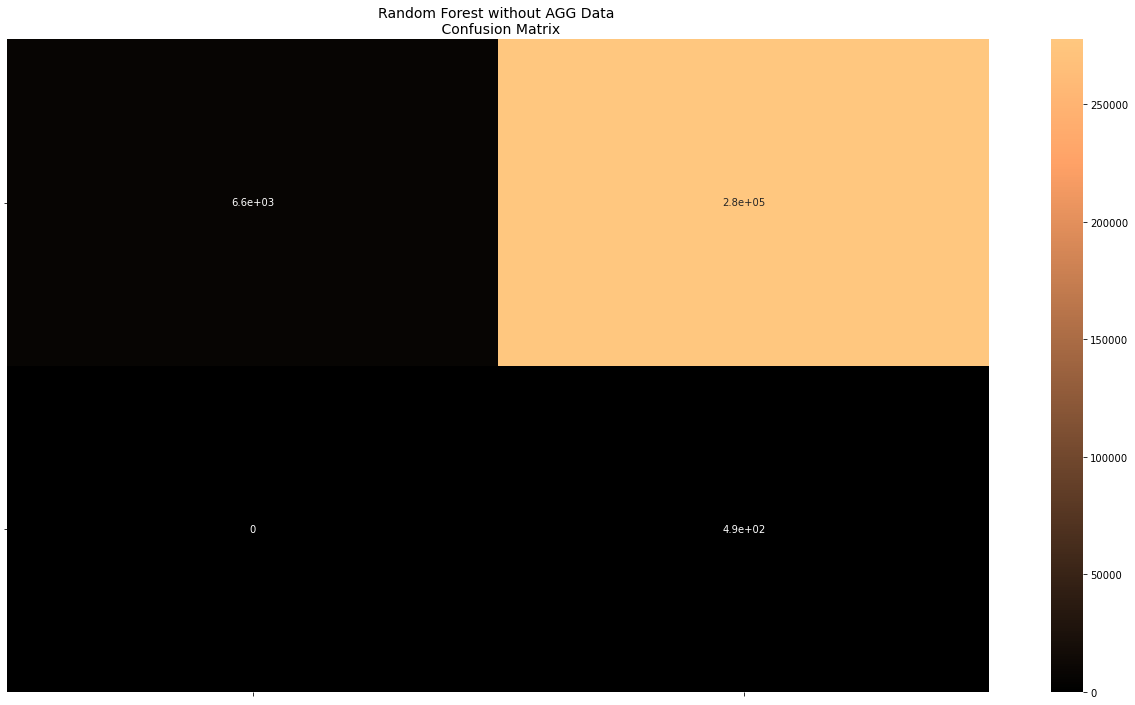

In [41]:
prediction_big_df = prediction_big.toPandas()
prediction_big_df= prediction_big_df[ (prediction_big_df.Class == 0) | (prediction_big_df.Class == 1)]

rf_cf_cm = confusion_matrix(
    list(prediction_big_df['Class']),
    list(prediction_big_df['prediction'])
)

fig, ax = plt.subplots(1, 1,figsize=(22,12))

sns.heatmap(rf_cf_cm,ax=ax, annot=True, cmap=plt.cm.copper)
ax.set_title("Random Forest without AGG Data \n Confusion Matrix", fontsize=14)
ax.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax.set_yticklabels(['', ''], fontsize=14, rotation=360)

# Very bad graph, As you can see, only 55% of our predictions are with correct label, 
# and we cannot identify classes correcly yet
plt.show()

In [42]:
df3.count()

284808

In [43]:
# Let's try to do an aggregating technique on very unbalanced data
# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
df = df3.toPandas()
df = df[ (df.Class == 0) | (df.Class == 1)]
X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

    
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values
    
log_reg_sm = LogisticRegression()
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

/opt/conda/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 61, in _check_solver

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9489353470546199
precision: 0.05993653114637783
recall: 0.9162934112301201
f1: 0.11101623710546901
---------------------------------------------------------------------------------------------------------------------------------------


In [44]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.10      0.86      0.18        98

    accuracy                           0.99     56961
   macro avg       0.55      0.92      0.58     56961
weighted avg       1.00      0.99      0.99     56961



In [45]:
y_score = best_est.decision_function(original_Xtest)

In [46]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.70


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.70')

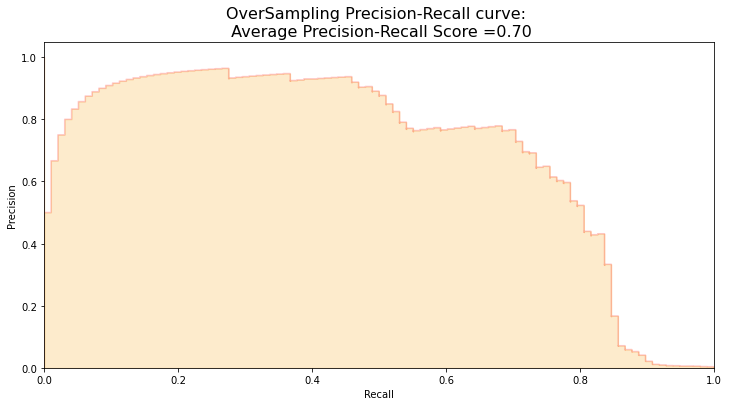

In [47]:

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [48]:

# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy='minority', random_state=42)

# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [49]:
data = pd.DataFrame(data=Xsm_train)
data['Class'] = ysm_train
data.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,-0.994302,0.0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,-0.994302,0.0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,-0.994290,0.0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,-0.994290,0.0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,-0.994279,0.0


In [50]:
spark_df = spark.createDataFrame(data)

In [51]:
spark_df.printSchema()

root
 |-- 0: double (nullable = true)
 |-- 1: double (nullable = true)
 |-- 2: double (nullable = true)
 |-- 3: double (nullable = true)
 |-- 4: double (nullable = true)
 |-- 5: double (nullable = true)
 |-- 6: double (nullable = true)
 |-- 7: double (nullable = true)
 |-- 8: double (nullable = true)
 |-- 9: double (nullable = true)
 |-- 10: double (nullable = true)
 |-- 11: double (nullable = true)
 |-- 12: double (nullable = true)
 |-- 13: double (nullable = true)
 |-- 14: double (nullable = true)
 |-- 15: double (nullable = true)
 |-- 16: double (nullable = true)
 |-- 17: double (nullable = true)
 |-- 18: double (nullable = true)
 |-- 19: double (nullable = true)
 |-- 20: double (nullable = true)
 |-- 21: double (nullable = true)
 |-- 22: double (nullable = true)
 |-- 23: double (nullable = true)
 |-- 24: double (nullable = true)
 |-- 25: double (nullable = true)
 |-- 26: double (nullable = true)
 |-- 27: double (nullable = true)
 |-- 28: double (nullable = true)
 |-- 29: double (nu

In [52]:
# Let fit RF again with data aggregated from SMOTE technique
cols = spark_df.columns
cols.remove('Class')
cols

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29']

In [53]:
assembler = VectorAssembler(inputCols=cols,outputCol='features')
rf_df = assembler.transform(spark_df)
rf_df.show()

22/05/30 07:34:06 WARN org.apache.spark.scheduler.TaskSetManager: Stage 256 contains a task of very large size (41749 KiB). The maximum recommended task size is 1000 KiB.


+------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+--------------------+-------------------+-----+--------------------+
|                 0|                  1|                 2|                  3|                  4|                  5|                   6|                  7|                 8|                  9|                10|                11|                 12|                 13|                 14|                 15|                  16|                 17|             

In [54]:
rf_df = rf_df.withColumn("labelIndex", rf_df.Class)
rf_df.columns

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 'Class',
 'features',
 'labelIndex']

In [55]:
rf_df_feat = rf_df.select('features','labelIndex')

In [56]:
(trainingData, testData) = rf_df_feat.randomSplit([0.7, 0.3],seed=1234)

In [57]:
rf_model = rf.fit(trainingData)

22/05/30 07:34:07 WARN org.apache.spark.scheduler.TaskSetManager: Stage 257 contains a task of very large size (41749 KiB). The maximum recommended task size is 1000 KiB.
22/05/30 07:34:16 WARN org.apache.spark.scheduler.TaskSetManager: Stage 260 contains a task of very large size (41749 KiB). The maximum recommended task size is 1000 KiB.
22/05/30 07:34:19 WARN org.apache.spark.scheduler.TaskSetManager: Stage 261 contains a task of very large size (41749 KiB). The maximum recommended task size is 1000 KiB.
22/05/30 07:34:26 WARN org.apache.spark.scheduler.TaskSetManager: Stage 262 contains a task of very large size (41749 KiB). The maximum recommended task size is 1000 KiB.
22/05/30 07:34:32 WARN org.apache.spark.scheduler.TaskSetManager: Stage 264 contains a task of very large size (41749 KiB). The maximum recommended task size is 1000 KiB.
22/05/30 07:34:38 WARN org.apache.spark.scheduler.TaskSetManager: Stage 266 contains a task of very large size (41817 KiB). The maximum recommend

In [58]:
predictions = rf_model.transform(testData)

In [59]:
evaluator = BinaryClassificationEvaluator(labelCol="labelIndex")
# We have only two choices: area under ROC and PR curves :-(
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(auroc))
# 0.9922 for PR Curve!!! very good results
print("Area under PR Curve: {:.4f}".format(auprc))

22/05/30 07:34:44 WARN org.apache.spark.scheduler.TaskSetManager: Stage 274 contains a task of very large size (41749 KiB). The maximum recommended task size is 1000 KiB.
22/05/30 07:34:50 WARN org.apache.spark.scheduler.TaskSetManager: Stage 285 contains a task of very large size (41749 KiB). The maximum recommended task size is 1000 KiB.


Area under ROC Curve: 0.9904
Area under PR Curve: 0.9922


22/05/30 07:34:56 WARN org.apache.spark.scheduler.TaskSetManager: Stage 299 contains a task of very large size (41749 KiB). The maximum recommended task size is 1000 KiB.
22/05/30 07:35:02 WARN org.apache.spark.scheduler.TaskSetManager: Stage 300 contains a task of very large size (41749 KiB). The maximum recommended task size is 1000 KiB.


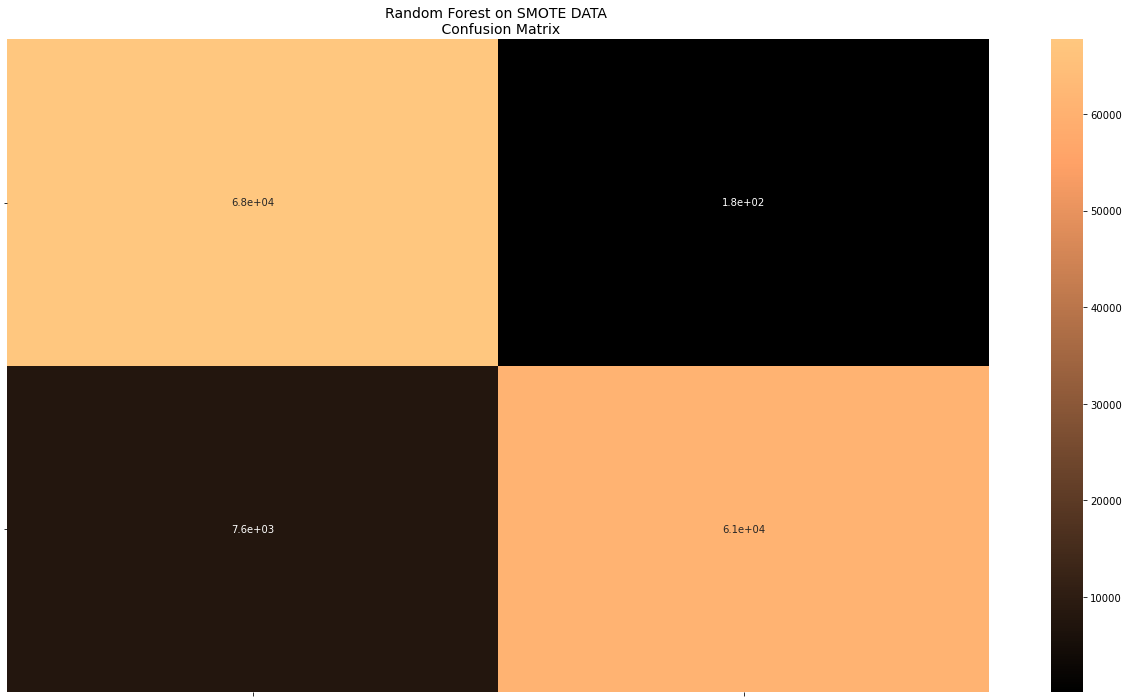

In [60]:
rf_cf_cm = confusion_matrix(
    list(testData.select('labelIndex').toPandas()['labelIndex']),
    list(predictions.select('prediction').toPandas()['prediction'])
)

fig, ax = plt.subplots(1, 1,figsize=(22,12))

sns.heatmap(rf_cf_cm,ax=ax, annot=True, cmap=plt.cm.copper)
ax.set_title("Random Forest on SMOTE DATA \n Confusion Matrix", fontsize=14)
ax.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax.set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.show()

In [61]:
# let's try to test it on our original dataframe (not aggregated by SMOTE)
prediction_big = rf_model.transform(rf_df1)
evaluator = BinaryClassificationEvaluator(labelCol="labelIndex")
auroc = evaluator.evaluate(prediction_big, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(prediction_big, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(auroc))
print("Area under PR Curve: {:.4f}".format(auprc))
# 75% corrrect ! we trained our RF to be 0.75, very good results for such unbalanced data

Area under ROC Curve: 0.9874
Area under PR Curve: 0.7522


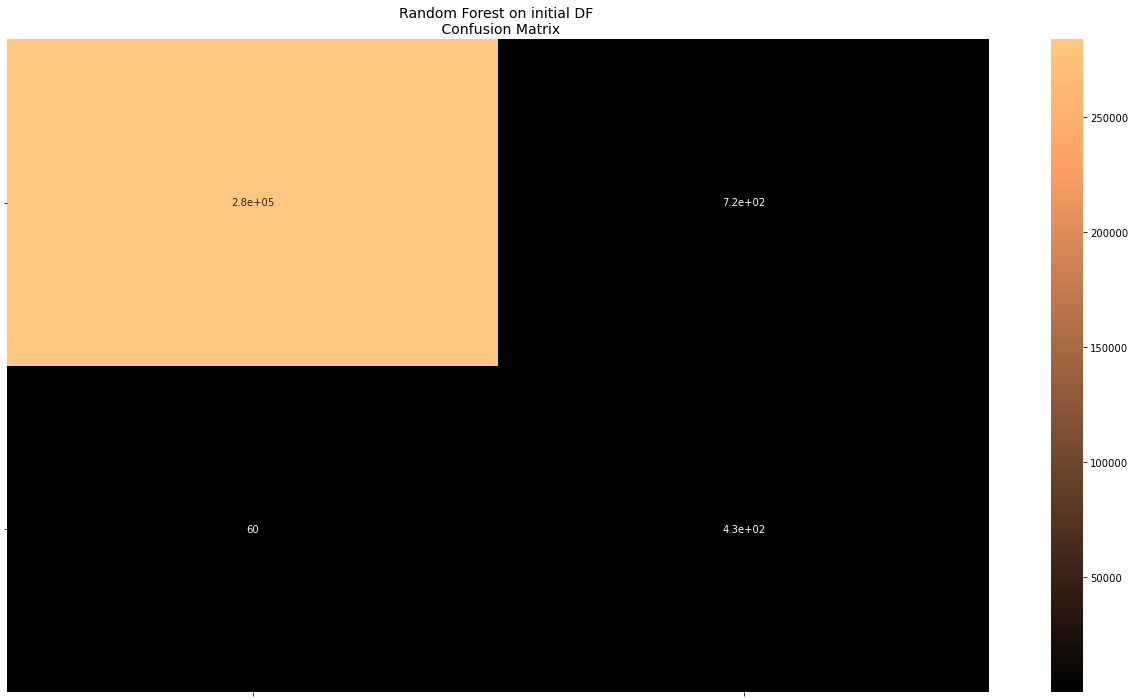

In [62]:
prediction_big_df = prediction_big.toPandas()
prediction_big_df= prediction_big_df[ (prediction_big_df.Class == 0) | (prediction_big_df.Class == 1)]

rf_cf_cm = confusion_matrix(
    list(prediction_big_df['Class']),
    list(prediction_big_df['prediction'])
)

fig, ax = plt.subplots(1, 1,figsize=(22,12))

sns.heatmap(rf_cf_cm,ax=ax, annot=True, cmap=plt.cm.copper)
ax.set_title("Random Forest on initial DF \n Confusion Matrix", fontsize=14)
ax.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax.set_yticklabels(['', ''], fontsize=14, rotation=360)

# very good results!
plt.show()

In [63]:
t1 = time.time()
print("Time in  :{} sec".format(t1 - t0))

Time in  :341.30646300315857 sec


In [64]:
#  spark.stop()